(pathfinder)=

# Pathfinder Variational Inference

:::{post} Sept 30, 2022 :tags: variational inference, jax :category: advanced :author: Thomas Wiecki :::

Pathfinder is a variational inference algorithm that produces samples from the posterior of a Bayesian model. It compares favorably to the widely used ADVI algorithm. On large problems, it should scale better than most MCMC algorithms, including dynamic HMC (i.e. NUTS), at the cost of a more biased estimate of the posterior. For details on the algorithm, see the [arxiv preprint](https://arxiv.org/abs/2108.03782).

This algorithm is [implemented](https://github.com/blackjax-devs/blackjax/pull/194) in [BlackJAX](https://github.com/blackjax-devs/blackjax), a library of inference algorithms for [JAX](https://github.com/google/jax). Through PyMC's JAX-backend (through [aesara](https://github.com/aesara-devs/aesara)) we can run BlackJAX's pathfinder on any PyMC model with some simple wrapper code.

This wrapper code is implemented in [pymc-experimental](https://github.com/pymc-devs/pymc-experimental/). This tutorial shows how to run Pathfinder on your PyMC model.

You first need to install `pymc-experimental`:

`pip install git+https://github.com/pymc-devs/pymc-experimental`

In [1]:
import arviz as az
import numpy as np
import pymc as pm

# Import pymc_experimental
import pymc_experimental as pmx

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.0


First, define your PyMC model. Here, we use the 8-schools model.

In [2]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as model:
    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    tau = pm.HalfCauchy("tau", 5.0)

    theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    theta_1 = mu + tau * theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, shape=J, observed=y)

Next, we call `pmx.fit()` and pass in the algorithm we want it to use.

In [3]:
with model:
    idata = pmx.fit(method="pathfinder")

/Users/twiecki/miniforge3/envs/pymc4/lib/python3.10/site-packages/pymc/sampling_jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Running pathfinder...
Transforming variables...


Just like `pymc.sample()`, this returns an idata with samples from the posterior. Note that because these samples do not come from an MCMC chain, convergence can not be assessed in the regular way.

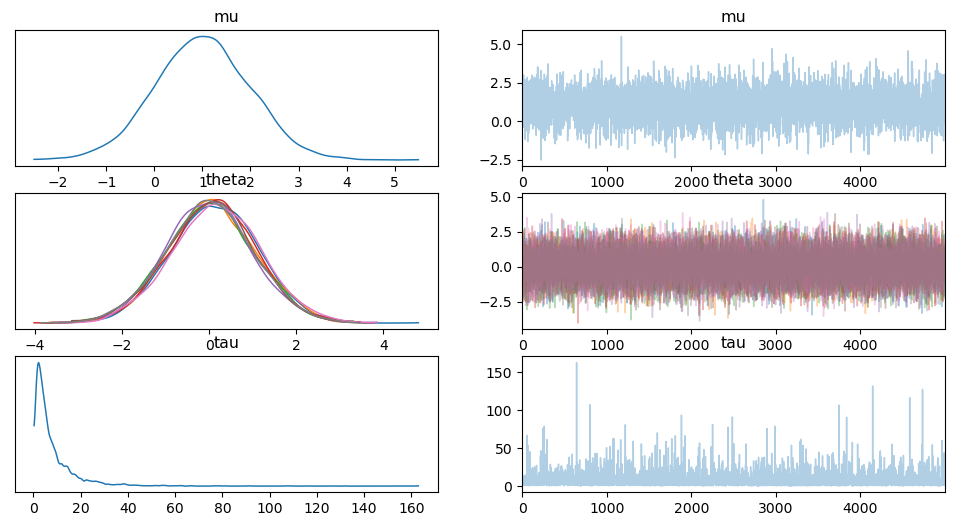

In [4]:
az.plot_trace(idata);

## Watermark

In [5]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,xarray

Last updated: Fri Sep 30 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: 2.8.2
xarray: 2022.6.0

pymc             : 4.2.0
arviz            : 0.12.1
numpy            : 1.22.4
pymc_experimental: 0.0.1

Watermark: 2.3.1

